
# Zcash Observatory data

- Eric Huang (speedup network)
- Pranav Thirunavukkarasu (observatory network)
- Mitchell Krawiec-Thayer (analysis)

June 2020

Observatory R & D at Insight supported by the Zcash Foundation


Expects directory structure:

```
/
|
├── *** THIS NOTEBOOK ***
|
├── node_name_1/
│   ├── blocks_v1.csv
│   └── inv_v1.csv
|
├── node_name_2/
│   ├── blocks_v1.csv
│   └── inv_v1.csv
|
├── node_name_3/
│   ├── blocks_v1.csv
│   └── inv_v1.csv
|
└── node_name_4/
    ├── blocks_v1.csv
    └── inv_v1.csv
```


## Import libraries

In [38]:
import numpy as np;
import matplotlib.pyplot as plt;
import math;
import os;
import pandas as pd;

## Settings for this notebook

In [39]:
### General Settings
path_to_files = '.'
savedata = 1 # boolean setting to export summary_df data frame
qverbose = 1 # how much text output do you want?

### Experimental settings:

# Ignore data below min_height. Set to 0 to process all data
min_height = 873961 
max_height = 874703

# If there's a ramp up time to connect to peers, mask experiment starts 
rt = 0 # set to 0 to dsable

## Experiment boundaries from the lab book
lab_book = pd.DataFrame(np.array([
    # Name            # Start    # End.  #state
    ['23', 873961, 873970, 'off'],
    ['23', 873971, 873980, 'on'],
    ['24', 873981, 873990, 'off'],
    ['24', 873991, 874000, 'on'],
    ['24', 874001, 874010, 'off'],
    ['24', 874011, 874020, 'on'],
    ['25', 874021, 874030, 'off'],
    ['25', 874031, 874040, 'on'],
    ['25', 874041, 874050, 'off'],
    ['25', 874051, 874060, 'on'],
    ['26', 874061, 874070, 'off'],
    ['26', 874071, 874080, 'on'],
    ['26', 874081, 874090, 'off'],
    ['26', 874091, 874100, 'on'],
    ['27', 874101, 874110, 'off'],
    ['27', 874111, 874120, 'on'],
    ['27', 874121, 874130, 'off'],
    ['27', 874131, 874140, 'on'],
    ['28', 874141, 874150, 'off'],
    ['28', 874151, 874160, 'on'],
    ['28', 874161, 874170, 'off'],
    ['28', 874171, 874180, 'on'],
    ['29', 874181, 874190, 'off'],
    ['29', 874191, 874200, 'on'],
    ['29', 874201, 874210, 'off'],
    ['29', 874211, 874220, 'on'],
    ['30', 874221, 874230, 'off'],
    ['30', 874231, 874240, 'on'],
    ['30', 874241, 874250, 'off'],
    ['30', 874251, 874260, 'on'],
    ['31', 874261, 874270, 'off'],
    ['31', 874271, 874280, 'on'],
    ['31', 874281, 874290, 'off'],
    ['31', 874291, 874300, 'on'],
    ['32', 874301, 874310, 'off'],
    ['32', 874311, 874320, 'on'],
    ['32', 874321, 874330, 'off'],
    ['32', 874331, 874340, 'on'],
    ['33', 874341, 874350, 'off'],
    ['33', 874351, 874360, 'on'],
    ['33', 874361, 874370, 'off'],
    ['33', 874371, 874380, 'on'],
    ['34', 874381, 874390, 'off'],
    ['34', 874391, 874400, 'on'],
    ['34', 874401, 874410, 'off'],
    ['34', 874411, 874420, 'on'],
    ['35', 874421, 874430, 'off'],
    ['35', 874431, 874440, 'on'],
    ['35', 874441, 874450, 'off'],
    ['35', 874451, 874460, 'on'],
    ['36', 874461, 874470, 'off'],
    ['36', 874471, 874480, 'on'],
    ['36', 874481, 874490, 'off'],
    ['36', 874491, 874500, 'on'],
    ['37', 874501, 874510, 'off'],
    ['37', 874511, 874520, 'on'],
    ['37', 874521, 874530, 'off'],
    ['37', 874531, 874540, 'on'],
    ['38', 874541, 874550, 'off'],
    ['38', 874551, 874560, 'on'],
    ['38', 874561, 874570, 'off'],
    ['38', 874571, 874580, 'on'],
    ['39', 874581, 874590, 'off'],
    ['39', 874591, 874600, 'on'],
    ['39', 874601, 874610, 'off'],
    ['39', 874611, 874620, 'on'],
    ['40', 874621, 874630, 'off'],
    ['40', 874631, 874640, 'on'],
    ['40', 874641, 874650, 'off'],
    ['40', 874651, 874660, 'on'],
    ['41', 874661, 874670, 'off'],
    ['41', 874671, 874680, 'on'],
    ['41', 874681, 874690, 'off'],
    ['41', 874691, 874700, 'on'],
    ]),                       
    columns=['comment', 'start_height', 'stop_height', 'state'])

# Show individual block prop CDFs?
show_n_indiv = 5 # just take a peek at a few

# Window width for plotting rolling averages
median_window = 48 # 1 hr

# Colors for plots
on_color = 'royalblue'
off_color = 'firebrick'
mean_color = 'orange'
median_color = 'springgreen'
no_state_color = 'lightgray'

### Random stuff, ignore or deprecate
min_obs_witness = 2 # Mask height unless witnessed by this number of observatories
sync_threshold = 0 # seconds interval for block inv messages
block_time = 75 # seconds
percentile_val = 98 # default for removed plots
prcts = (90,95,97) # don't touch this, hardcoded below, I'm sorry

## Display settings

Bigger text on plots

In [40]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

Disable scrolling

In [41]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Define functions
This function isn't used much, just a visualization

In [42]:
# This creates heatmap visualizations

def Heatmap(x, y, LinBins = (60,60), LogBins = (60,60), title = '', xlabel = '', ylabel = '', yscale = 'linear', xscale = 'linear', onlyplot = '', vmax = 'auto', vmin = 0, clabel='', ymax = 'auto'):
    # import numpy as np
    # import matplotlib.pyplot as plt
    # MPKT 2019.06

    # Note that this is a hacky function that cannot handle NaNs at the moment
    
    if ymax == 'auto':
        ymax_val = np.log10(int(np.max(x)))
    else:
        ymax_val = np.log10(int(ymax))
    
    # Log plot
    if not onlyplot == 'linear':
        fig = plt.figure(figsize=(15,5), facecolor='white')
        if len(LogBins) == 2:
            yedges = np.logspace(np.log10(1),ymax_val, LogBins[1])
        H, xedges, yedges = np.histogram2d(list(x),list(y), bins=(LogBins[1],yedges))
        
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        
        if vmax == 'auto':
            vmax = np.max(H)
        # Plot 2D histogram using pcolor
        plt.pcolormesh(xedges,yedges,H,vmax=vmax, vmin=vmin)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(clabel)                                          
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.show()
        
        return fig;

## Import data
Assumes that data is in directories named by node ID (location)

The cell that reads in CSV files also heavily processes, and may take minutes to run

### Analyze directory structure

In [43]:
# What are the nearby directories
folders = [x[0] for x in os.walk(path_to_files)]

# Initialize
node_names = list()
for f in range(len(folders)):
    this_folder_raw = folders[f]
    if not (this_folder_raw[0:3] == './.' or this_folder_raw == '.'):
        node_names.append(this_folder_raw[2::])
print('node_names:')
print (node_names)

node_names:
['africa', 'london', 'mumbai', 'virginia']


### Read in data from all nodes

In [44]:
# Import data, iterating over nodes

timestamps_df = pd.DataFrame()
heights_df = pd.DataFrame()
actual_node_names = ()

for f in range(len(node_names)):
    this_node_name = node_names[f]


    # Import height data
    blocks_file_name = os.path.join(this_node_name,'blocks_v1.csv')
    temp_df1 = pd.read_csv(blocks_file_name, index_col = 'Hash')
    temp_df1 = temp_df1.filter(["Hash", "Height", "Miner_Time", "Num_TX", "Difficulty"], axis=1)
    temp_df1['Obs_Node_Name'] = this_node_name
    heights_df = heights_df.append(temp_df1)

    # Import timestamp data
    heights_file_name = os.path.join(this_node_name,'inv_v1.csv')
    temp_df2 = pd.read_csv(heights_file_name, index_col = 'Hash')
    timestamps_df = timestamps_df.append(temp_df2)

# Join heights
all_data = timestamps_df.join(heights_df.drop_duplicates(), on='Hash') # temp hook

# Filter by height
all_data = all_data[all_data['Height']>min_height]
all_data = all_data[all_data['Height']<max_height]

## Data QC

### Peer piecewise analysis

What are all peers that we saw?

In [45]:
global_peerlist = list(set(all_data['Peer_IP']))

### Remove sync data (loop over peers)

In [46]:
heights_to_keep = list()
heights_to_mask = list()
non_sync_data = pd.DataFrame()

for p in range(len(global_peerlist)):
    if qverbose: 
        if p % 10 == 0:
            print("Peer " + str(p) + ' of ' + str(len(global_peerlist)))
    this_IP = global_peerlist[p]
    this_peer_data = all_data[all_data['Peer_IP'] == this_IP]
    this_peer_data = this_peer_data.reset_index()
    heights_seen_raw = list(set(this_peer_data['Height']))
    heights_seen = [x for x in heights_seen_raw if not np.isnan(x)]
    
    # De-dupe heights
    first_heard_df = this_peer_data.groupby(['Height'])['Validated_Time'].min().to_frame().reset_index()
    
    # Split into parallel lists
    height_array = list(first_heard_df["Height"])
    time_array = list(first_heard_df["Validated_Time"])

    for h in range(len(height_array)):
        # get data for this block
        this_height = height_array[h]
        this_time = time_array[h]
        
        # did the previous block exist
        last_height = this_height - 1
        try:
            last_height_index = height_array.index(last_height)
            last_time = time_array[last_height_index]
            
            if this_time - last_time > sync_threshold:
                heights_to_keep.append(this_height)
            else:
                # previous block was too recent
                heights_to_mask.append(this_height)
        except:
            # didn't see previous block
            heights_to_mask.append(this_height)
            

    # Okay, now remove those rows from the all-node this-peer data 
    for h in range(len(heights_to_mask)):
        this_height = heights_to_mask[h]
        idx = this_peer_data.index[this_peer_data['Height'] == this_height].tolist()
        
        if len(idx) > 0:
            if len(idx) > 1:
                for i in range(len(idx)):
                    this_peer_data.iat[i,1] = np.nan 
            else: # len(idx) == 1:
                this_peer_data.iat[idx[0],1] = np.nan 

    this_peer_data = this_peer_data.dropna()
    
    non_sync_data = non_sync_data.append(this_peer_data)

Peer 0 of 154
Peer 10 of 154
Peer 20 of 154
Peer 30 of 154
Peer 40 of 154
Peer 50 of 154
Peer 60 of 154
Peer 70 of 154
Peer 80 of 154
Peer 90 of 154
Peer 100 of 154
Peer 110 of 154
Peer 120 of 154
Peer 130 of 154
Peer 140 of 154
Peer 150 of 154


In [47]:
# summary_df = pd.DataFrame(columns=['Height','Hash','First_Time','Prop_Time','Obs_Witness_Count','Peers_Report_Count','Sorted_Timestamps'])

## Feature Engineering

Aggregate and derive data. 

If show_n_indiv > 1, will make plots of individual block propagation patterns

I haven't looked at these too closely yet. Later will compare during experiment vs control. Also need to switch histograms to log x bins

0 of 741
250 of 741
500 of 741


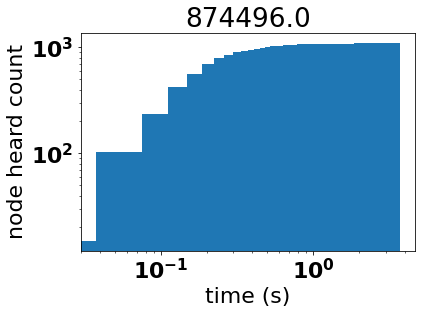

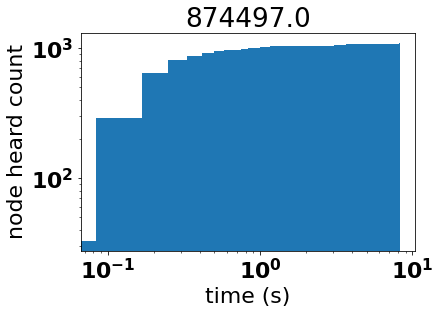

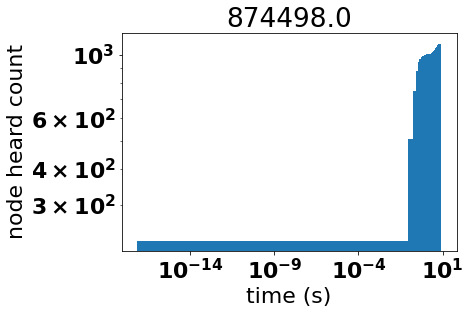

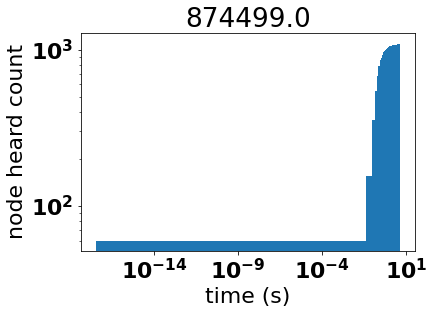

In [48]:
witness_df = pd.DataFrame()
global_height_list_raw = list(set(all_data['Height']))
global_height_list = [x for x in global_height_list_raw if not np.isnan(x)]
summary_df = pd.DataFrame(columns=['Height','Hash','First_Time','Prop_Time','Obs_Witness_Count','Peers_Report_Count','Sorted_Timestamps'])

# Define a bunch of columns.
height_col = list()
hash_col = list()
first_col = list()
prop_time_col = list()
obs_wit_col = list()
peers_col = list()
timestamps_col = list()
prct_prop_time_col = list()
miner_time_col = list()
num_tx_col = list()
difficulty_col = list()
prct_prop_time_col_50 = list()
prct_prop_time_col_75 = list()
prct_prop_time_col_90 = list()
prct_prop_time_col_95 = list()
prct_prop_time_col_97 = list()
prct_prop_time_col_99 = list()

pltcnt = 0
# Loop over heights
for h in range(len(global_height_list)):
    pltcnt = pltcnt + 1
    if qverbose > 0: 
        if h % 250 == 0:
            print(str(h) + ' of ' + str(len(global_height_list)))
    this_height = global_height_list[h]
    this_height_df = non_sync_data[non_sync_data["Height"] == this_height]
    height_col.append(this_height)
    # hash_col.append()
        
    try: 
        raw_times = this_height_df['Validated_Time']
        min_time = min(raw_times) # get the min time 
        max_allowed = min_time + block_time 
        allowed_times = raw_times[raw_times<max_allowed] 
        prop_times = allowed_times - min_time
        
        if pltcnt < show_n_indiv:
            fig = plt.figure()
            plt.hist(prop_times, cumulative=True, bins = 100)
            plt.xlabel('time (s)')
            plt.ylabel('node heard count')
            plt.title(str(this_height))
            plt.yscale('log')
            plt.xscale('log')

        max_time = max(allowed_times)
        prop_time = max_time - min_time       
        prct_prop_time = np.percentile(allowed_times,percentile_val)-min_time             
        prct_prop_time_50 = np.percentile(allowed_times,50)-min_time
        prct_prop_time_75 = np.percentile(allowed_times,75)-min_time
        prct_prop_time_90 = np.percentile(allowed_times,90)-min_time
        prct_prop_time_95 = np.percentile(allowed_times,95)-min_time
        prct_prop_time_97 = np.percentile(allowed_times,97)-min_time
        prct_prop_time_99 = np.percentile(allowed_times,99)-min_time
        
        if qverbose > 2: 
            print('***')
            print('Height: ' + str(this_height))
            print('Raw times: ' + str(raw_times))  
            print('Min time: '+ str(min_time))
            print('Max allowed: ' + str(max_allowed))
            print('Allowed times: ' + str(allowed_times))  
            print('Max time: ' + str(max_time))
            print('Prop time: ' + str(prop_time))
            print('Prct prop time: ' + str(prct_prop_time))

    except:
        # Record NaNs if data edge
        min_time = np.nan
        prop_time = np.nan
        prct_prop_time = np.nan
        prct_prop_time_50 = np.nan
        prct_prop_time_75 = np.nan
        prct_prop_time_90 = np.nan
        prct_prop_time_95 = np.nan
        prct_prop_time_97 = np.nan
        prct_prop_time_99 = np.nan
        if qverbose > 2: print('Except!')

    # Record values calculated above            
    first_col.append(min_time)
    prop_time_col.append(prop_time)
    prct_prop_time_col.append(prct_prop_time)
    prct_prop_time_col_50.append(prct_prop_time_50)
    prct_prop_time_col_75.append(prct_prop_time_75)
    prct_prop_time_col_90.append(prct_prop_time_90)
    prct_prop_time_col_95.append(prct_prop_time_95)
    prct_prop_time_col_97.append(prct_prop_time_97)
    prct_prop_time_col_99.append(prct_prop_time_99)
    
    # Count witnesses (how many observatory nodes)
    obs_witnesses = list(set(this_height_df["Obs_Node_Name"]))
    num_obs_witness = len(obs_witnesses) 
    obs_wit_col.append(num_obs_witness)
    
    # Count IPs (how many unique organic IP addresses)
    peers_reported = list(set(this_height_df["Peer_IP"]))
    num_peers_reported = len(peers_reported) 
    peers_col.append(num_peers_reported)   
    
    # Miner time (recorded in block)
    miner_time_col.append(int(min(this_height_df["Miner_Time"])))
    
    # Difficulty (recorded in block)
    difficulty_col.append(int(min(this_height_df["Difficulty"])))
    
    # Num TX (counted in block)
    num_tx_col.append(int(min(this_height_df["Num_TX"])))

#Bring it all together
summary_df['Height'] = height_col
summary_df['First_Time'] = first_col
summary_df['Prop_Time'] = prop_time_col
summary_df['Obs_Witness_Count'] = obs_wit_col
summary_df['Peers_Report_Count'] = peers_col
summary_df['Prct_Prop_Time'] = prct_prop_time_col
summary_df['Miner_Time'] = miner_time_col
summary_df['Block_Time_MRT'] = summary_df.diff()['Miner_Time'] # Also add miner_time difference
summary_df['Last_Block_Prop_Time'] = summary_df.shift()['Prop_Time']
summary_df['Last_Block_Prct_Prop_Time'] = summary_df.shift()['Prct_Prop_Time']
summary_df['num_tx'] = num_tx_col
summary_df['Difficulty'] = difficulty_col
summary_df['prct_prop_time_col_50'] = prct_prop_time_col_50
summary_df['prct_prop_time_col_75'] = prct_prop_time_col_75
summary_df['prct_prop_time_col_90'] = prct_prop_time_col_90
summary_df['prct_prop_time_col_95'] = prct_prop_time_col_95
summary_df['prct_prop_time_col_97'] = prct_prop_time_col_97
summary_df['prct_prop_time_col_99'] = prct_prop_time_col_99

summary_df = summary_df.sort_values(by='Height', ascending=True)

### Take a look at the data frame we just created and populated

In [49]:
summary_df.head()

,Height,Hash,First_Time,Prop_Time,Obs_Witness_Count,Peers_Report_Count,Sorted_Timestamps,Prct_Prop_Time,Miner_Time,Block_Time_MRT,Last_Block_Prop_Time,Last_Block_Prct_Prop_Time,num_tx,Difficulty,prct_prop_time_col_50,prct_prop_time_col_75,prct_prop_time_col_90,prct_prop_time_col_95,prct_prop_time_col_97,prct_prop_time_col_99
207,873962.0,NaN,1.592708e+09,10.978,3,123,NaN,2.39400,1592707651,-55670.0,4.144,1.67700,3,469929488,0.1790,0.28700,0.5010,0.987,1.646,3.23800
208,873963.0,NaN,1.592708e+09,27.894,3,150,NaN,12.83734,1592707746,95.0,10.978,2.39400,4,469930316,0.1855,0.28575,0.6837,2.277,12.815,13.69500
209,873964.0,NaN,1.592708e+09,23.939,3,150,NaN,8.13400,1592707748,2.0,27.894,12.83734,2,469930175,0.2060,0.38600,1.4360,3.281,8.085,8.96188
210,873965.0,NaN,1.592708e+09,18.216,3,150,NaN,2.33800,1592707753,5.0,23.939,8.13400,1,469931580,0.2050,0.65900,1.0405,2.210,2.280,13.36609
211,873966.0,NaN,1.592708e+09,3.887,3,150,NaN,3.08300,1592707760,7.0,18.216,2.33800,1,469928426,0.1880,0.28700,0.4532,1.002,1.754,3.59668


## Visualize data

### Probability density function plot

First, let's look at histograms of the global propagation time.

The first plot uses linear axes, and the second plot shows the same thing with log axes.

This is called the "probability density function" (PDF)

(ALL BLOCKS: these plots do not account for speedup experiments yet)

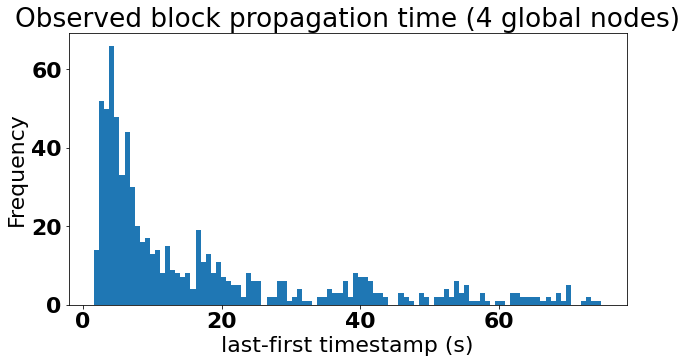

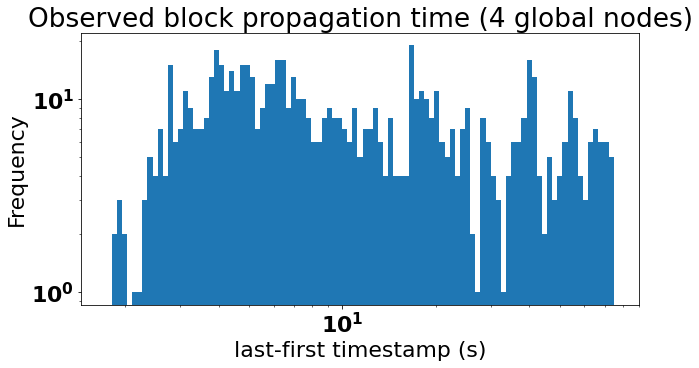

In [50]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(summary_df['Prop_Time'], bins=100)
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
hdata = summary_df['Prop_Time']
plt.hist(summary_df['Prop_Time'], bins=np.logspace(np.log10(min(hdata)+0.1),np.log10(max(hdata)),100));
plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)');

### Cumulative distribution function plot

Now let's look at a closely-related plot, the "cumulative distribution function" (CDF)

Crosshairs have been added to show how to interpret this plot. (Note that when the data are updated, the static crosshairs may not match up with the plot / data anymore)

For a given crosshair, <y-axis coordinate> fraction of blocks propagate in under <x-axis coordinate> seconds
    
Black line shows that 50% of blocks propagate in under 250 ms. Red line shows that 85% of blocks propagate in under 850 ms (meaning that 15% of Zcash blocks take more than 800 ms to propagate)

(ALL BLOCKS: these plots do not account for speedup experiments yet)

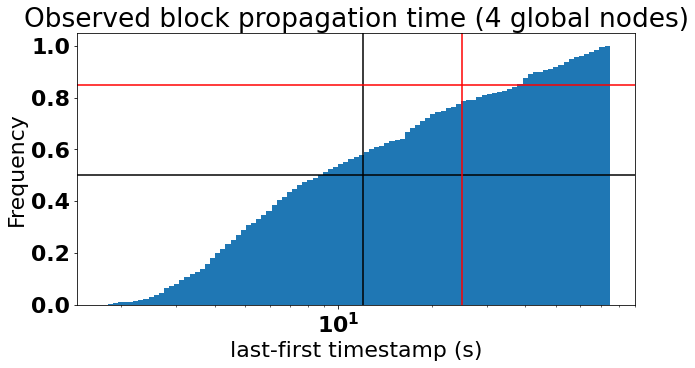

In [51]:
# Generate plot

height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(summary_df['Prop_Time'], bins=np.logspace(np.log10(min(hdata)+0.1),np.log10(max(hdata)),100), cumulative=True, density=True);
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (s)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')


# Add labels to explain
plt.axvline(x=12, color='black')
plt.axhline(y=0.5, color='black')
plt.axvline(x=25, color='red')
plt.axhline(y=0.85, color='red');

### Scatter plot

Now let's plot each block as a dot where x-axis is the block height, and y-axis is the observed global propagation time

Scatter plots by varying percentiles. Right now it just spams over all recorded percentiles

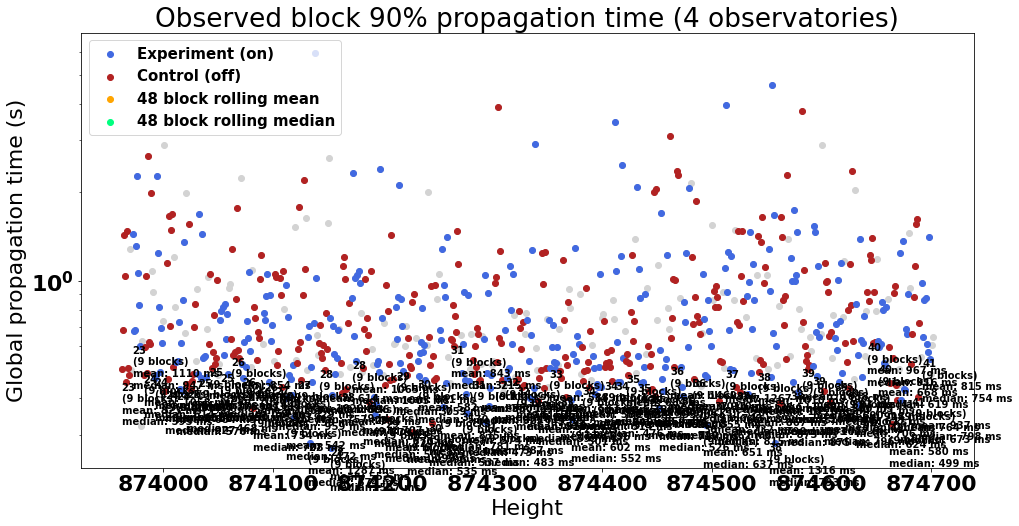

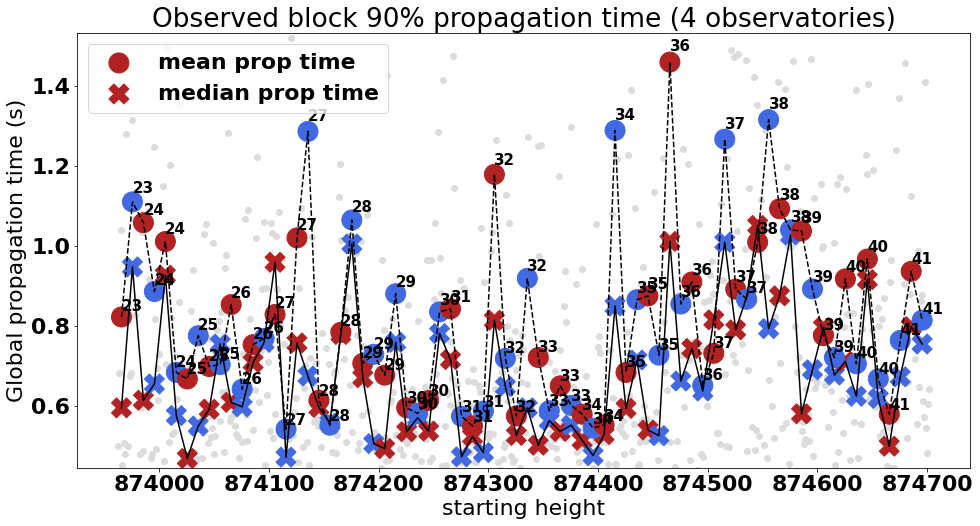

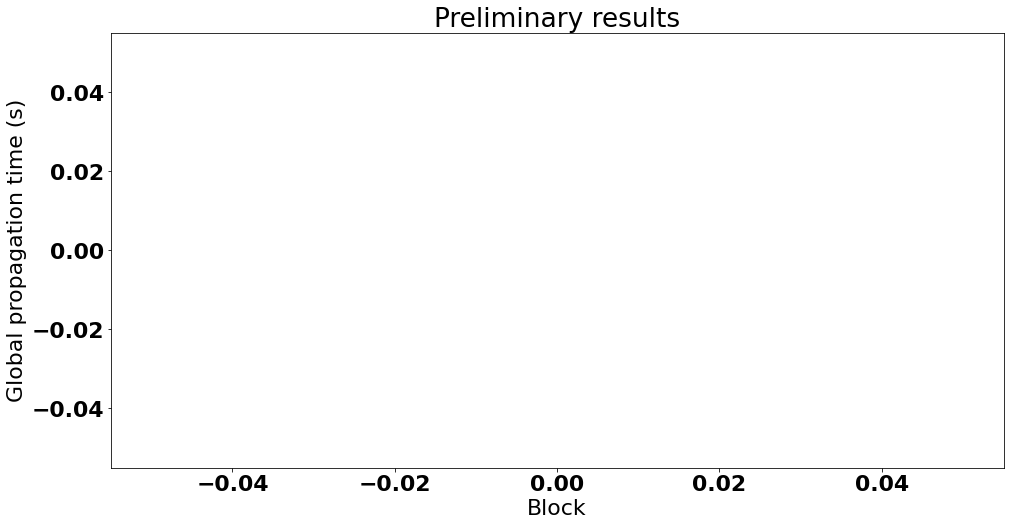

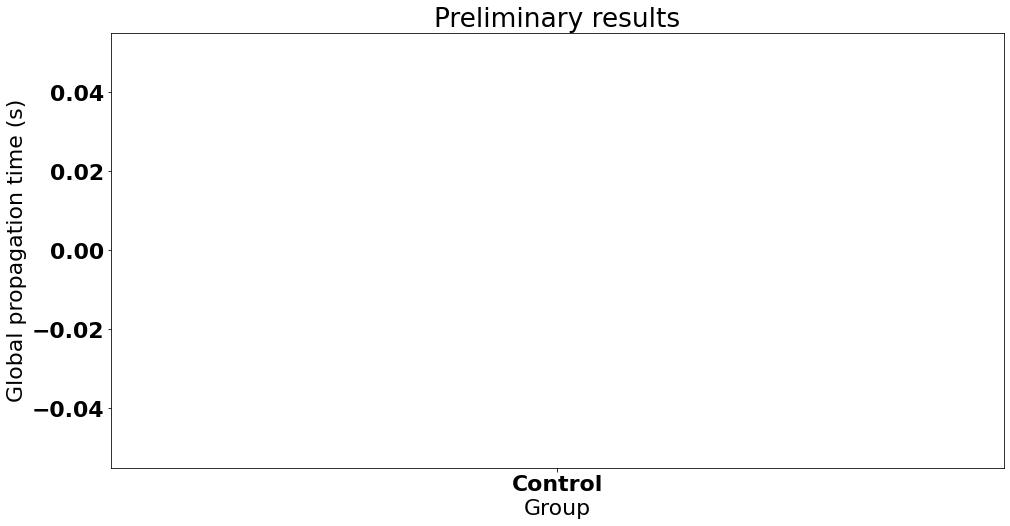

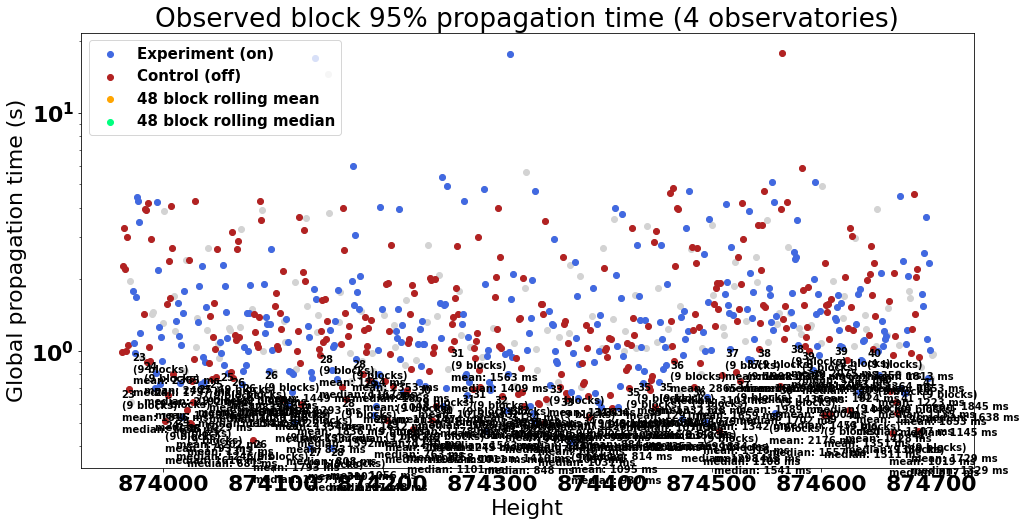

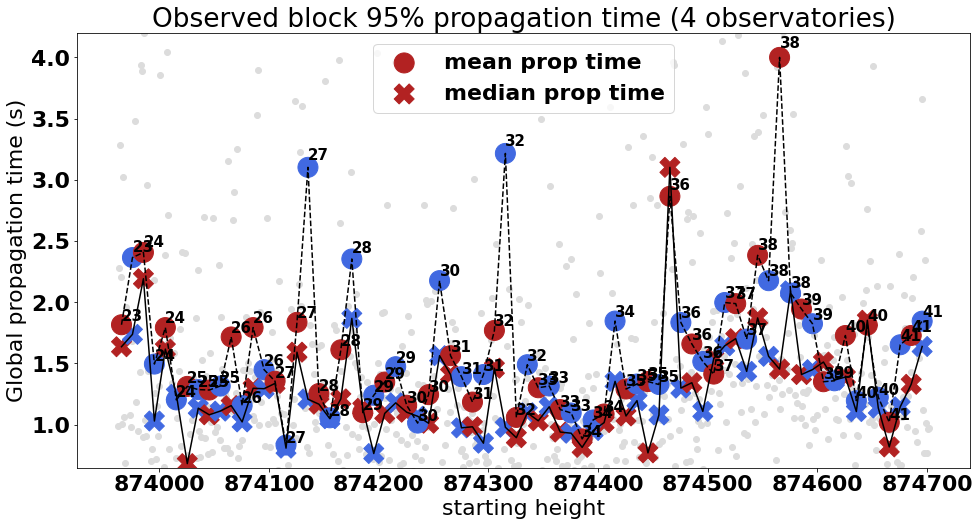

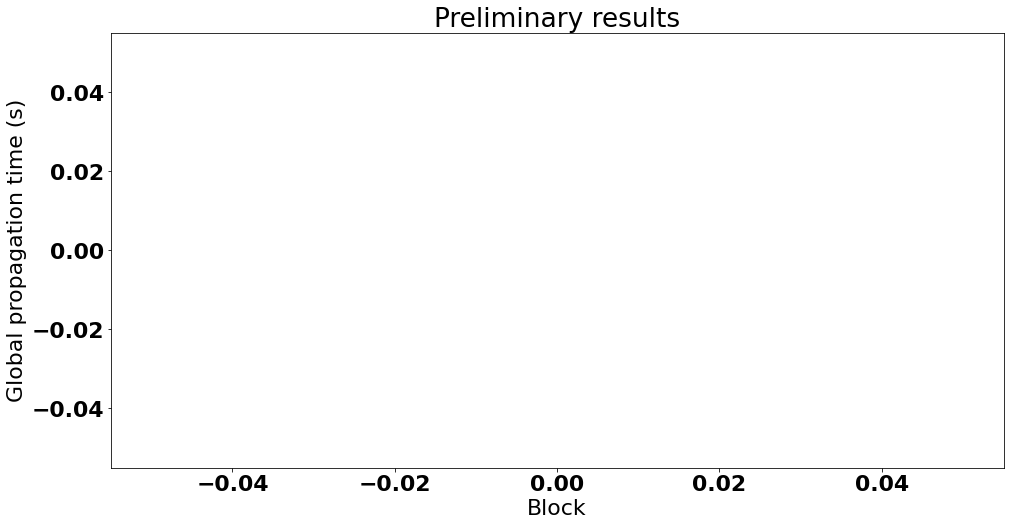

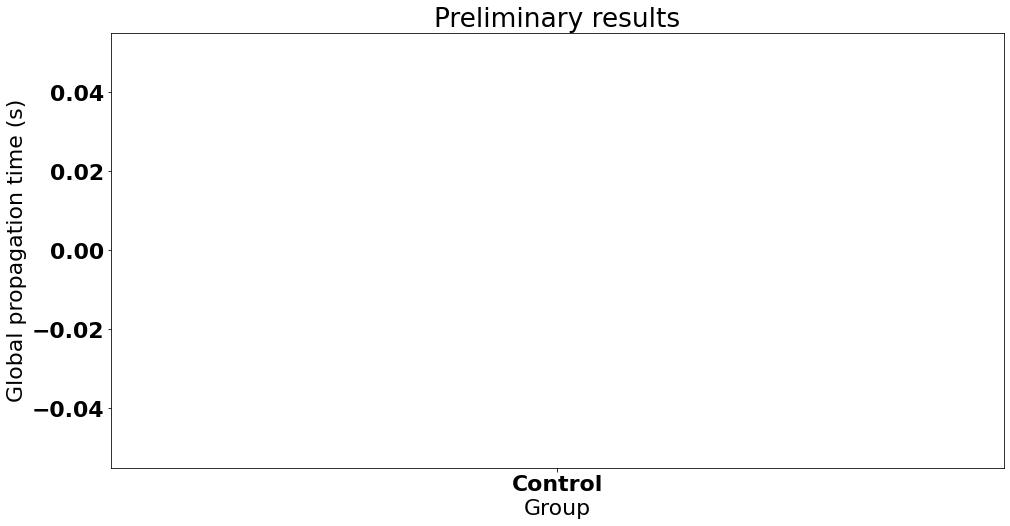

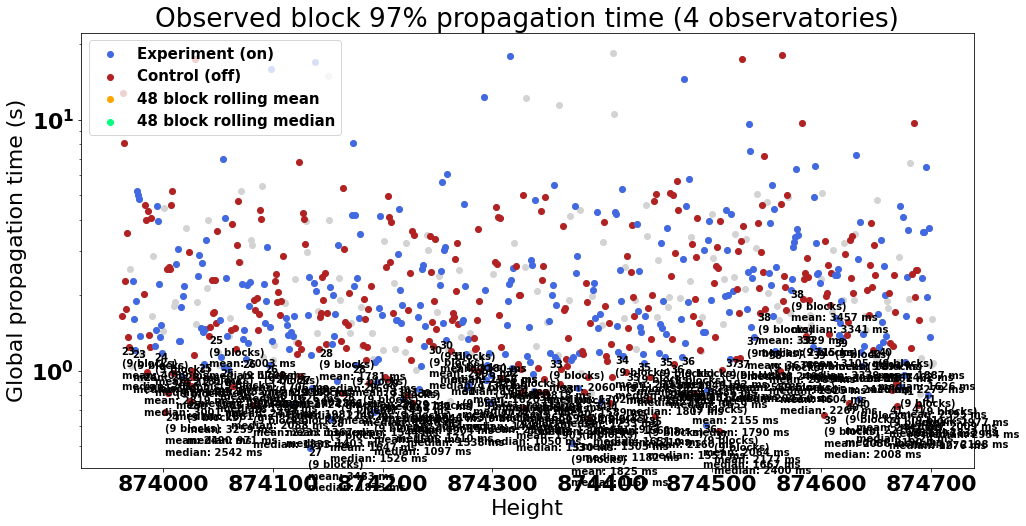

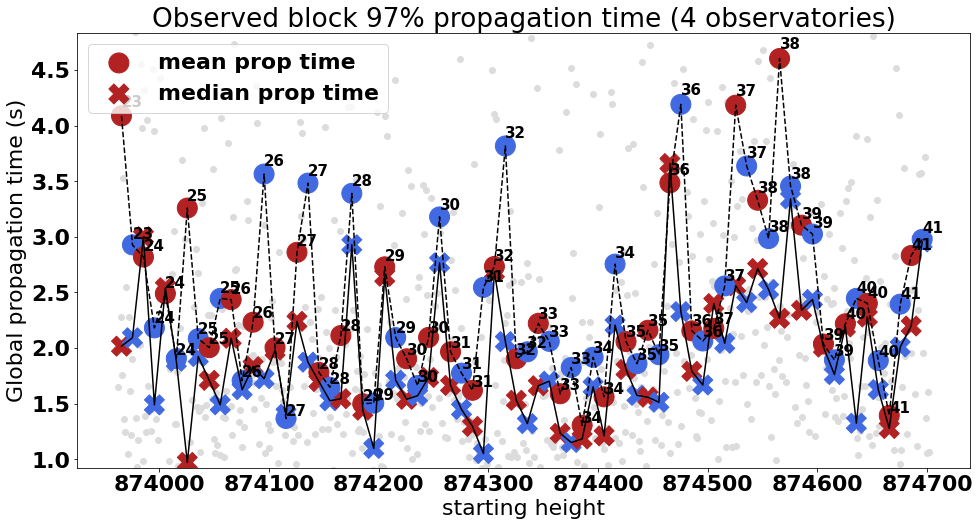

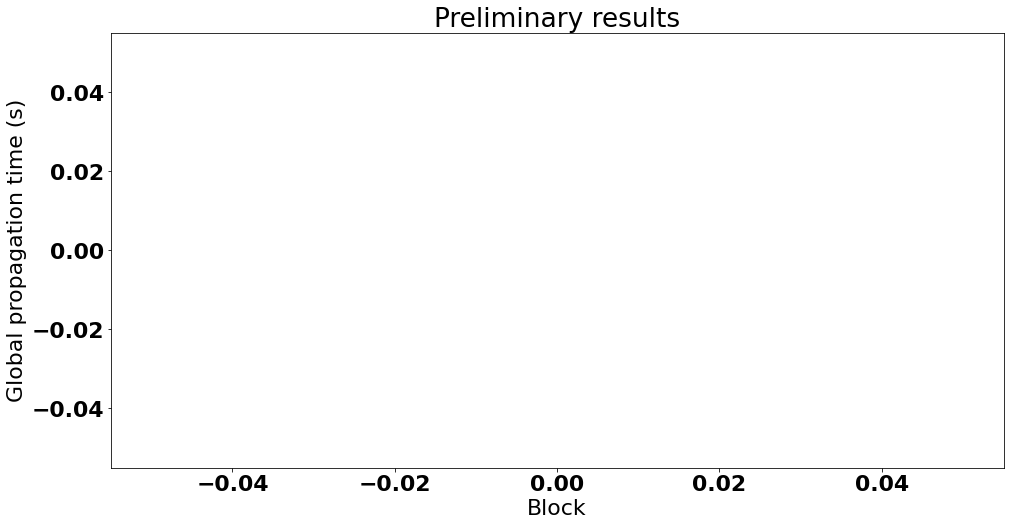

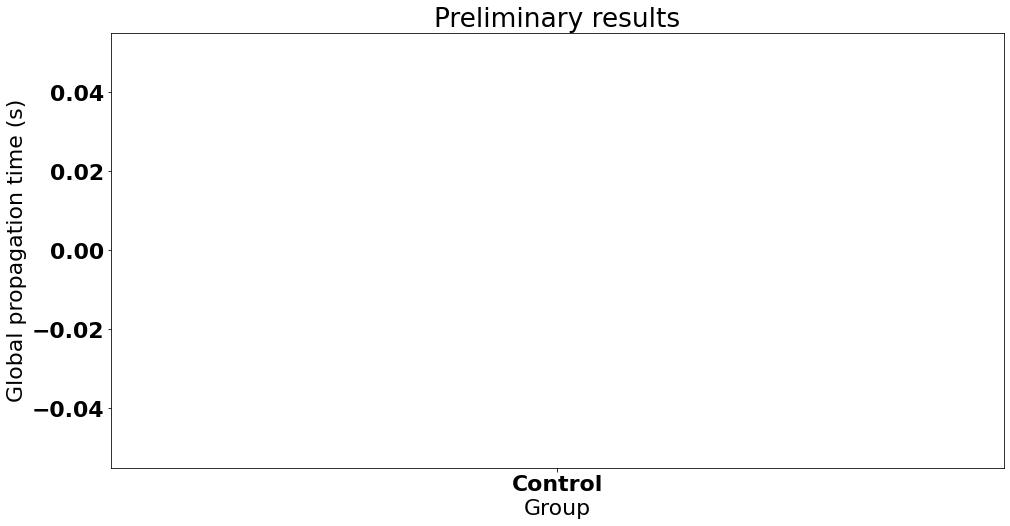

In [71]:
for p in range(len(prcts)): 
    on_mean = list()
    off_mean = list()
    on_heights = list()
    off_heights = list()
    this_prct = prcts[p]
    this_colname = 'prct_prop_time_col_' + str(this_prct)
    
    fig = plt.figure(figsize=(16,8), facecolor='w')
    plt.xlabel('last-first timestamp (s)')
    plt.ylabel('Global propagation time (s)')
    plt.title('Observed block '+ str(this_prct) + '% propagation time ('+str(len(node_names))+' observatories)');
    plt.scatter(summary_df['Height'],summary_df[this_colname], c=no_state_color)

    height_list = list()
    mean_list = list()
    median_list = list()
    state_list = list()
    comment_list = list()
    
    
    for index, row in lab_book.iterrows():
        start_height = row['start_height']
        stop_height = row['stop_height']
        state = row['state']
        comment = row['comment']

        to_plot = 0
        
        chop_low = summary_df[summary_df['Height'] > int(start_height)]
        chop_high = chop_low[chop_low['Height'] < int(stop_height)]
        block_count = int(stop_height) - int(start_height)
        median_val = np.median(chop_high[this_colname])
        mean_val = np.mean(chop_high[this_colname])
        if qverbose > 2:
            print('*****')
            print(comment + ' - ' + this_colname)
            print(str(start_height) + ' - ' + str(stop_height))
            print('Median: ' + str(median_val))
            print('Mean: ' + str(mean_val))

        if state == 'on':
            this_color = on_color
            state_list.append(on_color)
            to_plot = 1
            #on_mean.append(mean_val)
            #on_heights.append(chop_high['Height'])
        if state == 'off':
            this_color = off_color
            state_list.append(off_color)
            to_plot = 1
            #off_mean.append(mean_val)
            #off_heights.append(chop_high['Height'])
        
        # for bar plot
        height_list.append((int(start_height)+int(stop_height))/2)
        mean_list.append(mean_val)
        median_list.append(median_val)
        comment_list.append(comment)
        
        if to_plot:                                                  
            # Scatter plot of timeseries with rolling averages               
            if len(chop_low) > 0:
                meanval = chop_high[this_colname].rolling(window=median_window).mean()
                # Plot data
                if state == 'on':
                    on_trace = plt.scatter(x=chop_high['Height'], y=chop_high[this_colname], c=this_color)
                    on_heights.append(chop_high['Height'])
                    on_mean.append(meanval)
                if state == 'off':
                    off_trace = plt.scatter(x=chop_high['Height'], y=chop_high[this_colname], c=this_color)
                    off_heights.append(chop_high['Height'])
                    off_mean.append(meanval)
                
                # Add label
                try:
                    xval = min(chop_high['Height'])
                    yval = np.percentile(chop_high[this_colname], 0)
                    pltstr = comment + '\n('+ str(block_count) + ' blocks)'    +    '\nmean: '+ str(round(1000*mean_val)) + ' ms\nmedian: ' + str(int(1000*median_val)) + ' ms'
                    plt.text(xval,yval,pltstr,fontsize=10, horizontalalignment='left',verticalalignment='top')
                except:
                    pass
                
                # Calc rollings
                chop_high = chop_high.sort_values(by='Height')
                rolling_mean = chop_high[this_colname].rolling(window=median_window).mean()
                mean_trace = plt.scatter(chop_high.Height, rolling_mean, label='hour rolling window (mean)', color=mean_color)
                rolling_median = chop_high[this_colname].rolling(window=median_window).median()
                median_trace = plt.scatter(chop_high.Height, rolling_median, label='hour rolling window (median)', color=median_color)


    plt.xlabel('Height')
    plt.ylabel('Global propagation time (s)')
    plt.yscale('log')
    plt.axis('tight')
    plt.title('Observed block '+ str(this_prct) + '% propagation time ('+str(len(node_names))+' observatories)');
    try:
        plt.legend((on_trace, off_trace, mean_trace, median_trace), ('Experiment (on)', 'Control (off)', str(median_window) + ' block rolling mean',str(median_window) + ' block rolling median'), fontsize=15, loc='upper left')
    except:
        pass
    plt.show()
    
    
    #######
    # Plot with medians/means
    fig = plt.figure(figsize=(16,8), facecolor='w')
    plt.xlabel('starting height')
    plt.ylabel('Global propagation time (s)')
    plt.title('Observed block '+ str(this_prct) + '% propagation time ('+str(len(node_names))+' observatories)');
    
    
    
    #### TO-DO: ADD MEDIAN AND MEAN FILTERING BY EXP/CTRL
    
    plt.scatter(summary_df['Height'], summary_df[this_colname], color='gainsboro')
    rolling_mean = summary_df[this_colname].rolling(window=median_window).mean()
    # mean_trace = plt.scatter(summary_df.Height, rolling_mean, label='hour rolling window (mean)', color=mean_color, alpha = 0.2)
    rolling_median = summary_df[this_colname].rolling(window=median_window).median()
    # median_trace = plt.scatter(summary_df.Height, rolling_median, label='hour rolling window (median)', color=median_color, alpha = 0.2)

    # MEDIAN
    plt.plot(height_list, median_list, '-k')
    tr_median = plt.scatter(height_list, median_list, c=state_list, s=400, marker='X')
    
    # MEAN
    plt.plot(height_list, mean_list, '--k')
    tr_mean = plt.scatter(height_list, mean_list, c=state_list, s=400)
  
    plt.legend((tr_mean, tr_median), ('mean prop time','median prop time'))
    
    #plt.xticks(height_list, comment_list, rotation='vertical')
     
    for r in range(len(comment_list)):
        plt.text(height_list[r], mean_list[r]*1.02, comment_list[r], fontsize=15)
    
    plt.ylim((min(mean_list + median_list)*.95,max(mean_list + median_list)*1.05))
    
    #plt.xticks(y_pos, bars)
    plt.show()
    
    hl = []
    for index, element in enumerate(height_list):
        if index % 2 == 0:
            hl.append(element)
    ############# prelim results
    fig = plt.figure(figsize=(16,8), facecolor='w')
    plt.xlabel('Block')
    plt.ylabel('Global propagation time (s)')
    plt.title('Preliminary results');
    plt.plot(hl, on_mean)
    plt.plot(hl, off_mean)
    plt.show()
    
    
    groups = ["Control", "Experiment"]
    means = [(sum(off_mean)/len(off_mean)), (sum(on_mean)/len(on_mean))]
    fig = plt.figure(figsize=(16,8), facecolor='w')
    plt.xlabel('Group')
    plt.ylabel('Global propagation time (s)')
    plt.title('Preliminary results');
    plt.plot(groups, means)
    plt.show()

### Impact on block discovery time:

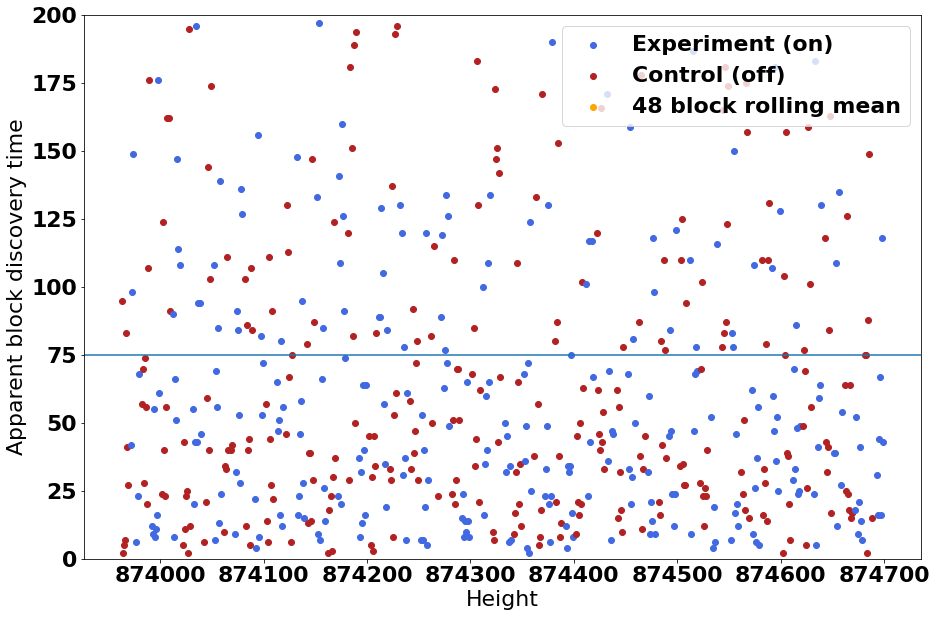

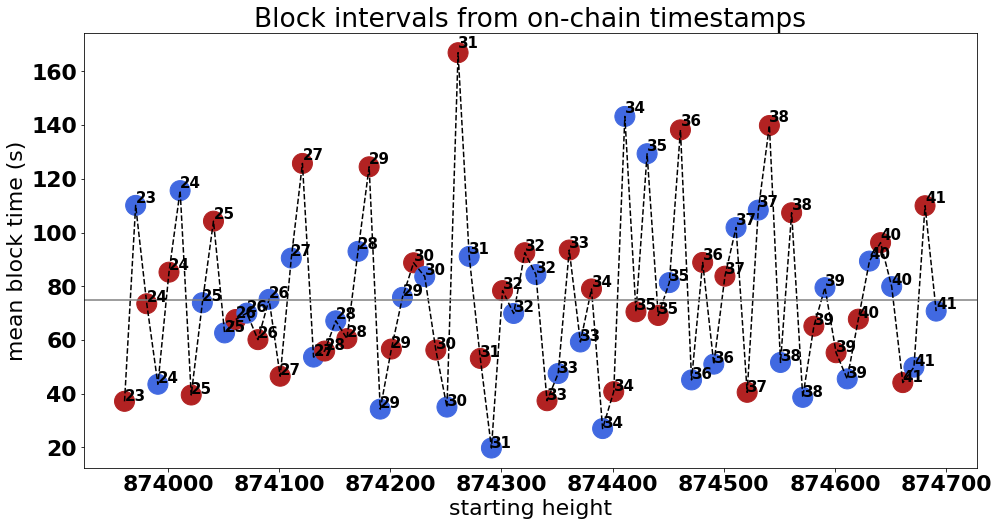

In [53]:
fig = plt.figure(figsize=(15,10), facecolor='white')



height_list = list()
state_list = list()
comment_list = list()
median_interval_list = list()
mean_interval_list = list()

for index, row in lab_book.iterrows():
    start_height = row['start_height']
    stop_height = row['stop_height']
    state = row['state']
    comment = row['comment']
    
    to_plot = 0
    chop_low = summary_df[summary_df['Height'] > int(start_height)]
    chop_high = chop_low[chop_low['Height'] < int(stop_height)]
    chop_high = chop_high.sort_values(by='Height')
    chop_high = chop_high[chop_high['Block_Time_MRT']>0]
    
    mean_val = np.mean(chop_high['Block_Time_MRT'])
    median_val = np.median(chop_high['Block_Time_MRT'])
        
    if qverbose > 1:
        print('*****')
        print(comment + ': ' + str(start_height) + ' - ' + str(stop_height) + ' ('+ str(int(stop_height) - int(start_height)) + ' blocks)')
        #print('Median: ' + str(np.median(chop_high[this_colname])))
        print('on-chain block interval mean: ' + str(mean_val))
        print('on-chain difficulty: ' + str(np.mean(chop_high['Difficulty'])))

    if state == 'on':
        this_color = on_color
        state_list.append(on_color)
        to_plot = 1
    if state == 'off':
        this_color = off_color
        state_list.append(off_color)
        to_plot = 1

    # for bar plot
    height_list.append(int(start_height))
    comment_list.append(comment)              
    median_interval_list.append(median_val)
    mean_interval_list.append(mean_val)
    
    if to_plot:
        if len(chop_low) > 0:
            # Plot data
            if state == 'on':
                on_trace = plt.scatter(x=chop_high['Height'], y=chop_high['Block_Time_MRT'], c=this_color)
            if state == 'off':
                off_trace = plt.scatter(x=chop_high['Height'], y=chop_high['Block_Time_MRT'], c=this_color)


            # Calc rollings
            rolling_mean = chop_high['Block_Time_MRT'].rolling(window=median_window).mean()
            mean_trace = plt.scatter(chop_high.Height, rolling_mean, label='hour rolling window (mean)', color=mean_color)
            # rolling_median = chop_high[this_colname].rolling(window=median_window).median()
            #median_trace = plt.scatter(chop_high.Height, rolling_median, label='hour rolling window (median)', color=median_color)


plt.xlabel('Height')
plt.ylabel('Apparent block discovery time')
plt.ylim((0,200))
plt.axhline(y=75)
#plt.axis('tight')
#plt.xlim((870240,871203))
#plt.title('Observed block '+ str(this_prct) + '% propagation time ('+str(len(node_names))+' observatories)');
# plt.xlim((int(start_height), max(summary_df['Height']))) ### TEMP
try:
    plt.legend((on_trace, off_trace, mean_trace, median_trace), ('Experiment (on)', 'Control (off)', str(median_window) + ' block rolling mean',str(median_window) + ' block rolling median'))
    plt.legend((on_trace, off_trace, mean_trace), ('Experiment (on)', 'Control (off)', str(median_window) + ' block rolling mean'))
except:
    pass
    


#######
# Plot with medians/means
fig = plt.figure(figsize=(16,8), facecolor='w')
plt.xlabel('starting height')
plt.ylabel('mean block time (s)')
plt.title('Block intervals from on-chain timestamps');

# MEDIAN
# plt.plot(height_list, median_interval_list, '-k')
# tr_median = plt.scatter(height_list, median_interval_list, c=state_list, s=400, marker='X')

# MEAN
plt.plot(height_list, mean_interval_list, '--k')
tr_mean = plt.scatter(height_list, mean_interval_list, c=state_list, s=400)

# plt.legend((tr_mean, tr_median), ('median','mean'))

#plt.xticks(height_list, comment_list, rotation='vertical')

for r in range(len(comment_list)):
    plt.text(height_list[r], mean_interval_list[r]*1.01, comment_list[r], fontsize=15)

plt.axhline(y=75, c='gray')

#plt.xticks(y_pos, bars)
plt.show()


Are the experiments impacting miner reported block time?

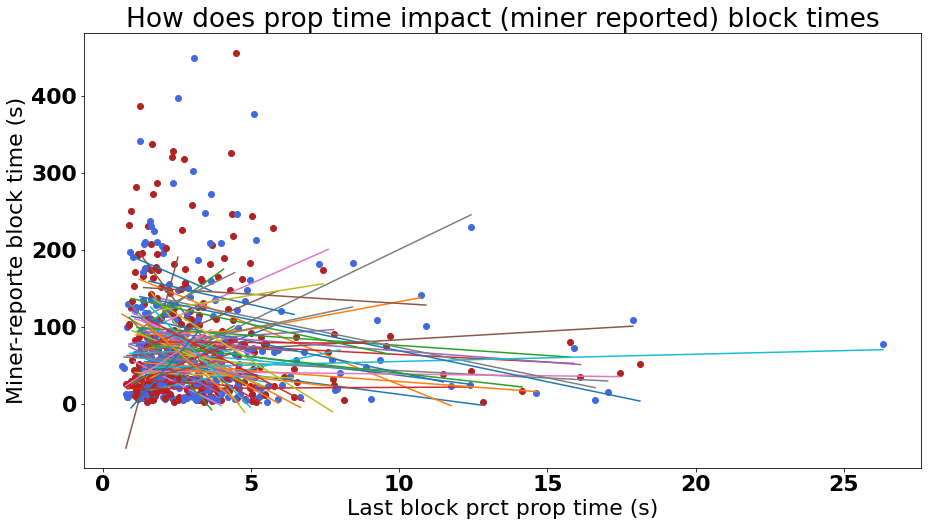

In [54]:
fig = plt.figure(figsize=(15,8), facecolor='w')
plt.xlabel('Last block prct prop time (s)')
plt.ylabel('Miner-reporte block time (s)')
#plt.title('Observed block '+ str(percentile_val) + '% propagation time ('+str(len(node_names))+' observatories)');
plt.title('How does prop time impact (miner reported) block times')

for index, row in lab_book.iterrows():
    start_height = row['start_height']
    stop_height = row['stop_height']
    state = row['state']

    to_plot = 0
    if state == 'on':
        this_color = on_color
        to_plot = 1
    if state == 'off':
        this_color = off_color
        to_plot = 1
        
    if to_plot:
        chop_zero = summary_df[summary_df['Block_Time_MRT'] > -1*block_time]
        chop_low = chop_zero[chop_zero['Height'] > int(start_height)]
        chop_high = chop_low[chop_low['Height'] < int(stop_height)]
        chop_high = chop_high.sort_values(by='Height')

        if len(chop_low) > 0:
            # Plot data
            plt.scatter(x=chop_high['Last_Block_Prct_Prop_Time'], y=chop_high['Block_Time_MRT'], c=this_color)
            try:
                plt.plot(np.unique(chop_high['Last_Block_Prct_Prop_Time']), np.poly1d(np.polyfit(chop_high['Last_Block_Prct_Prop_Time'], chop_high['Block_Time_MRT'], 1))(np.unique(chop_high['Last_Block_Prct_Prop_Time'])))
            except:
                pass
    
    

## Save data
Data frame to CSV if desired

In [55]:
if savedata:
    summary_df.to_csv('summary_df.csv', index_label = 'block_hash')

## Experimental analyses

### Heatmap plots
(same concept as the scatter plots above, except shaded)

These plots are finicky and need some tuning, but luckily they don't matter much here.

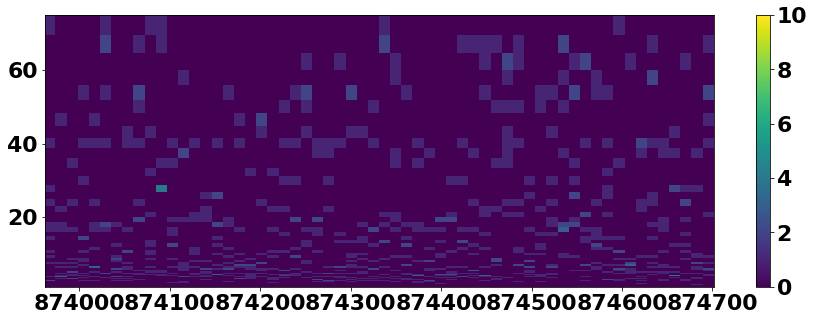

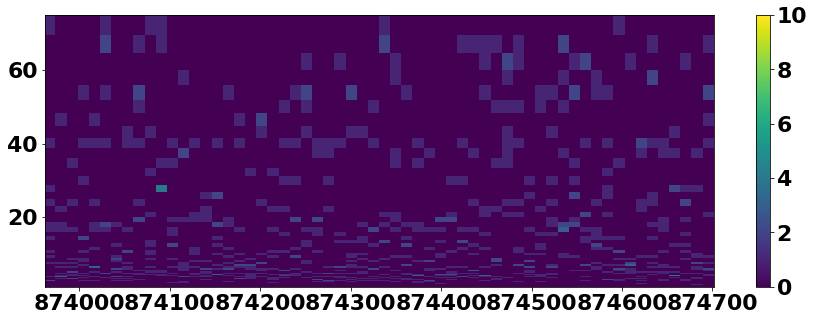

In [56]:
Heatmap(x=summary_df['Height'], y=summary_df['Prop_Time'], ymax=75, vmax=10)

### Does num_tx (poor proxy for block size) impact prop time?

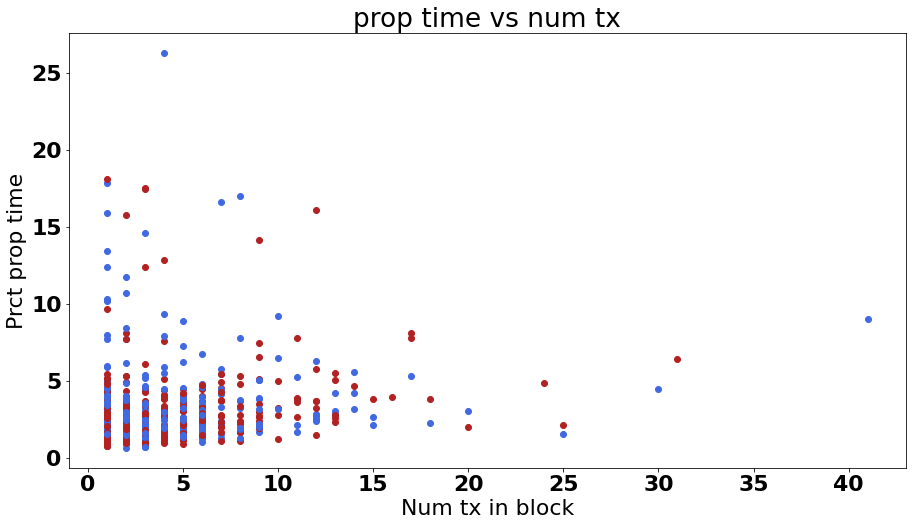

In [57]:
fig = plt.figure(figsize=(15,8), facecolor='w')
plt.xlabel('Num tx in block')
plt.ylabel('Prct prop time')
#plt.title('Observed block '+ str(percentile_val) + '% propagation time ('+str(len(node_names))+' observatories)');
plt.title('prop time vs num tx')

for index, row in lab_book.iterrows():
    start_height = row['start_height']
    stop_height = row['stop_height']
    state = row['state']

    to_plot = 0
    if state == 'on':
        this_color = on_color
        to_plot = 1
    if state == 'off':
        this_color = off_color
        to_plot = 1
        
    if to_plot:
        chop_zero = summary_df[summary_df['Block_Time_MRT'] > -1*block_time] # unnecessary here
        chop_low = chop_zero[chop_zero['Height'] > int(start_height)]
        chop_high = chop_low[chop_low['Height'] < int(stop_height)]
        
        if len(chop_low) > 0:
            # Plot data
            plt.scatter(x=chop_high['num_tx'], y=chop_high['Prct_Prop_Time'], c=this_color)
            try:
                pass
            except:
                pass
    
    

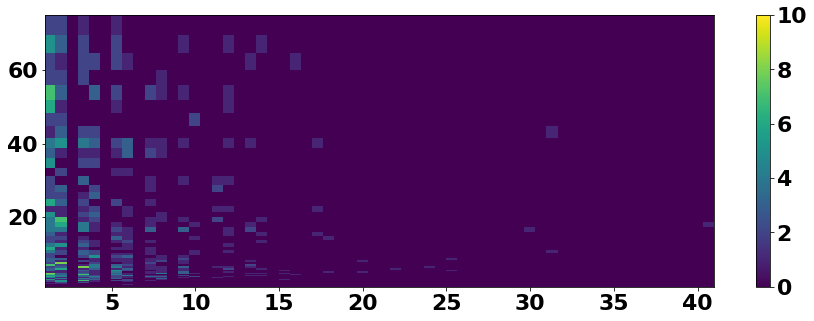

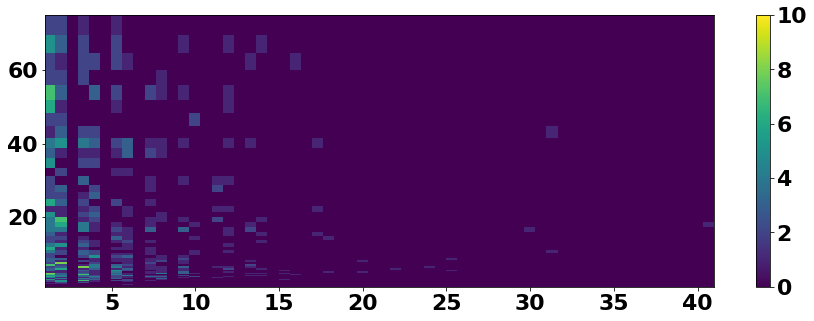

In [58]:
Heatmap(x=summary_df['num_tx'], y=summary_df['Prop_Time'], ymax=75, vmax=10, LinBins = (35,35))

## Looking at prop profile by num tx.

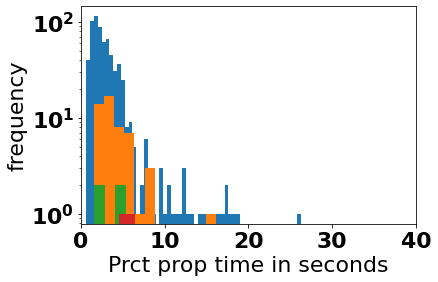

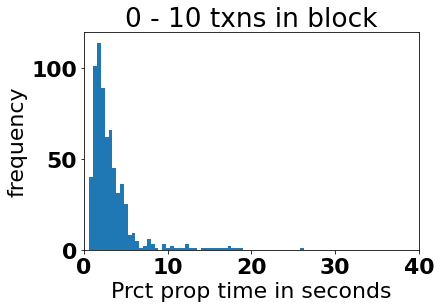

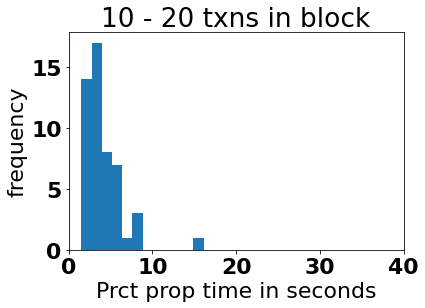

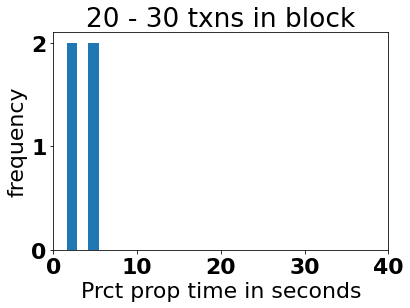

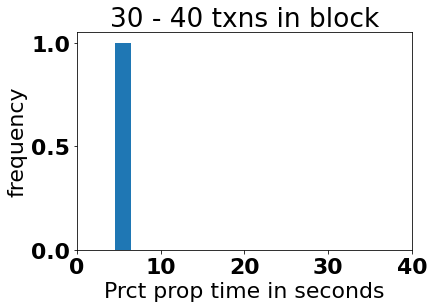

In [59]:
bin_size = 10
max_tx = 35
fig = plt.figure()

for t in range(int(max_tx/bin_size+1)):
    low_end = t*bin_size
    high_end = low_end + bin_size
    chop_low = summary_df[summary_df['num_tx'] > low_end]
    chop_high = chop_low[chop_low['num_tx'] < high_end] 
    #a = np.hstack(subdf['Prct_Prop_Time'])
    plt.hist(chop_high['Prct_Prop_Time'], bins='auto')  # arguments are passed to np.histogram
    plt.xlim((0,40))
    plt.xlabel('Prct prop time in seconds')
    plt.ylabel('frequency')
    plt.yscale('log')



for t in range(int(max_tx/bin_size+1)):
    low_end = t*bin_size
    high_end = low_end + bin_size
    chop_low = summary_df[summary_df['num_tx'] > low_end]
    chop_high = chop_low[chop_low['num_tx'] < high_end] 
    #a = np.hstack(subdf['Prct_Prop_Time'])
    fig = plt.figure()
    plt.hist(chop_high['Prct_Prop_Time'], bins='auto')  # arguments are passed to np.histogram
    plt.title(str(low_end) + ' - ' + str(high_end) + ' txns in block')
    plt.xlim((0,40))
    plt.xlabel('Prct prop time in seconds')
    plt.ylabel('frequency')

### Does propagation impact miner timestamps?

Let's look at the distribution of miner-reported block times

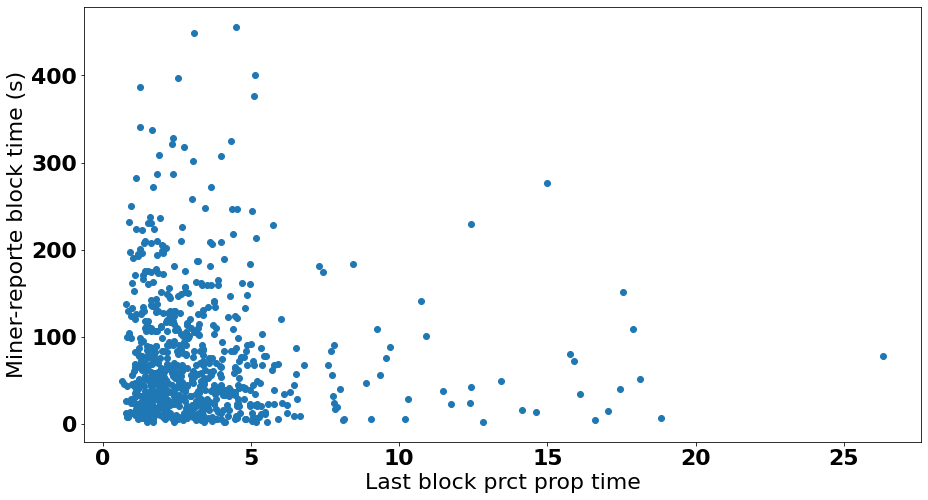

In [60]:
fig = plt.figure(figsize=(15,8), facecolor='w')
chop_zero = summary_df[summary_df['Block_Time_MRT'] > -1*block_time]
plt.xlabel('Last block prct prop time')
plt.ylabel('Miner-reporte block time (s)')
#plt.title('Observed block '+ str(percentile_val) + '% propagation time ('+str(len(node_names))+' observatories)');
plt.scatter(chop_zero['Last_Block_Prct_Prop_Time'],chop_zero['Block_Time_MRT'])
